<h1>Introduction</h1>

This dataset is included in the [Amazon fraud benchmark datasets](https://github.com/amazon-science/fraud-dataset-benchmark) which include a variety of datasets for testing and benchmarking purposes. The eCommerce Fraud dataset stands out in that the benchmark performances are particularly poor - the highest benchmark AUROC = 0.636 was achieved by AFD TFI, none of the AutoML models do not achieve AUROC > 0.55. This is very low for a benchmark dataset. There is also limited information about this dataset, as there are no data descriptions are given in the [kaggle page](https://www.kaggle.com/vbinh002/fraud-ecommerce).

In this project, we explore this data to better understand why even enterprise-grade detection softwares performed so poorly. We then engineer new features and construct a prediction model that is able to capture the idiosyncrasis of this dataset, hopefully outperforming the benchmarks. 

The dataset used in this project was downloaded directly from Kaggle.

The dataset contains 151,112 transactions, comprising 136,961 legitimate transactions (90.6%) and 14,151 fraudulent transactions (9.36%). 

Variables Included:

    user_id, signup_time, purchase_time, purchase_value, device_id, source, browser, sex, age, ip_address, class

    

<h1>Result Summary</h1>

- The shortest time_to_first_purchase observed amongst legitimate transactions was 137 seconds.

- 7,600 transactions have a time_to_first_purchase of exactly 1 second, all of these are fraudulent.

- Excluding transactions where time_to_first_purchase = 1 second, the shortest fraudulent time_to_first_purchase is 769 seconds.

- We observed 760 ip_address that are associated with multiple transactions. 8360 transactions originate from these non-unique ip_address. of these, 7634 transactions are fraudulent.

- We observed 6175 device_id that are associated with multiple transactions. 19331 transactions originate from these non-unique ip_address. of these, 10141 transactions are fraudulent.

- Chi-squared tests on the browser and source variables show statistically significant differences between fraudulent and legitimate transactions.

- We observed several anomalous behaviour in the data which strongly suggest that this dataset is synthetic. Some of the more obvious ones include:

1. several transactions exhibit highly unusual patterns. For example, the device_id YLDDOCJIVHEJV is assocaited 4 transactions from 4 ip address in 4 different countries and 4 different sex and age over a period of 7 months. This device also registered transactions from both IE and Safari browsers which is technically unfeasible. Additionally, of these 4 transactions, only 1 is marked as fraudulent

2. 21966 observations are associated with one of 21013 IP address that cannot be mapped to a country

3. All transactions with seconds_to_first_purchase <= 1 are fraudulent, with the fastest legitimate transaction taking 137 seconds. After dropping transactions with seconds_to_first_purchase <=1, the remaining values of seconds_to_first_purchase appears to follow a uniform distribution for both fraudulent and legetimate transactions.

4. Fraudulent purchases from the same device ID have a 1 second interval


<h1>Prediction model </h1>

We constructed a simple decision tree classifier using 5 features: 
- fast_transaction : bool
        time_to_first_purchase in seconds < 45
- repeated_ip_address: bool
        ip address in either training OR testing set
- repeated_device_id: bool
        device_id in either training OR testing set
- browser: str
        the browser used
- source: str
        the source of the purchase

We were able to achieved an average AUROC, precision, and recall of 0.769, 1, and 0.537 respectively across 5-fold cross validations. Outperforming the benchmark AUROC of 0.636. 


<h1> Conclusion </h1>
This data is very likely to be synthetic and contains various anomalies not usually present in real-world datasets. We believe that the anomalous nature of the data throws off fraud detection models calibrated on real-world data thus leading to the low benchmark performances observed.

This file was also uploaded to the dataset [kaggle page](https://www.kaggle.com/vbinh002/fraud-ecommerce).

In [27]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [5]:
purchase_data = pd.read_csv('data\ecommfraud\Fraud_Data.csv')
ip_data = pd.read_csv('data\ecommfraud\IpAddress_to_Country.csv')

<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
C:\Users\MingX\AppData\Local\Temp\ipykernel_17580\3819648352.py:1: SyntaxWarning: invalid escape sequence '\e'
  purchase_data = pd.read_csv('data\ecommfraud\Fraud_Data.csv')
C:\Users\MingX\AppData\Local\Temp\ipykernel_17580\3819648352.py:2: SyntaxWarning: invalid escape sequence '\e'
  ip_data = pd.read_csv('data\ecommfraud\IpAddress_to_Country.csv')


In [7]:
ip_data

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


In [ ]:
# derive time_to_first_purchase and convert to seconds
purchase_data["time_to_first_purchase"] = pd.to_datetime(purchase_data["purchase_time"]) - pd.to_datetime(purchase_data["signup_time"])
purchase_data['seconds_to_first_purchase'] = purchase_data["time_to_first_purchase"].dt.total_seconds()

<Axes: ylabel='Count'>

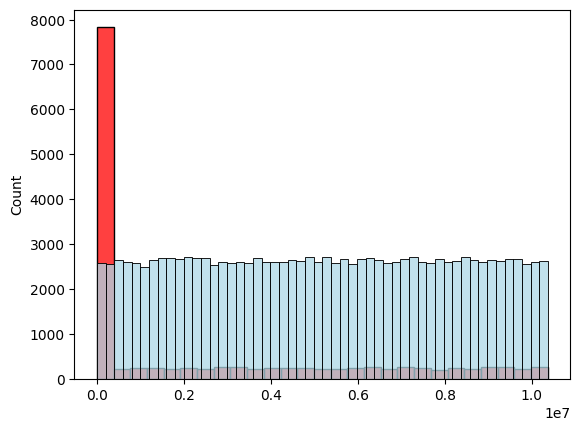

In [161]:
sns.histplot([i.total_seconds() for i in purchase_data.loc[purchase_data['class'] ==1 , "time_to_first_purchase"]], color='red')
sns.histplot([i.total_seconds() for i in purchase_data.loc[purchase_data['class'] ==0 , "time_to_first_purchase"]], color='lightblue')

<Axes: xlabel='purchase_value', ylabel='Density'>

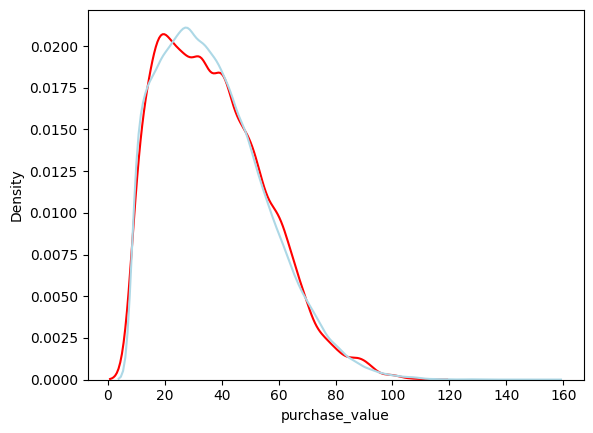

In [167]:
sns.kdeplot(purchase_data.loc[purchase_data['class'] ==1 , "purchase_value"], color='red')
sns.kdeplot(purchase_data.loc[purchase_data['class'] ==0 , "purchase_value"], color='lightblue')

In [168]:
stats.kstest(purchase_data.loc[purchase_data['class'] ==0 , "purchase_value"] , purchase_data.loc[purchase_data['class'] ==1 , "purchase_value"])

KstestResult(statistic=0.011553688322815836, pvalue=0.06464410554939426, statistic_location=23, statistic_sign=-1)

<Axes: xlabel='age', ylabel='Density'>

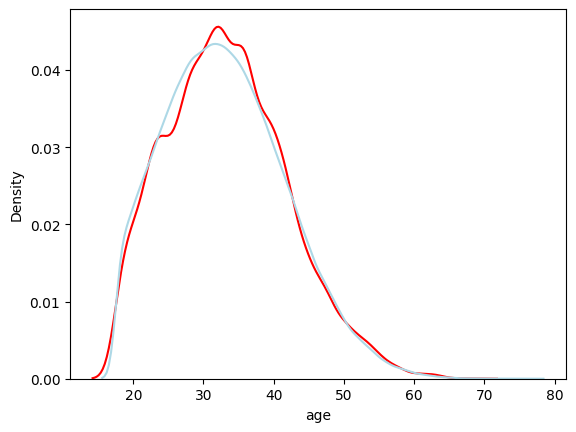

In [166]:
sns.kdeplot(purchase_data.loc[purchase_data['class'] ==1 , "age"], color='red')
sns.kdeplot(purchase_data.loc[purchase_data['class'] ==0 , "age"], color='lightblue')

In [169]:
stats.kstest(purchase_data.loc[purchase_data['class'] ==0 , "age"] , purchase_data.loc[purchase_data['class'] ==1 , "age"])

KstestResult(statistic=0.019750843366254878, pvalue=8.894844539272973e-05, statistic_location=31, statistic_sign=1)

even thought the KS-test is significant, the shape of the KDE looks too similar for me to confidently use age as a feature

we now examine the device id variable

In [12]:
purchase_data['device_id'].nunique()

137956

In [14]:
repeated_device_ids = purchase_data['device_id'].value_counts() > 1
repeated_device_ids = repeated_device_ids[repeated_device_ids].index.tolist()

In [16]:
len(repeated_device_ids)

6175

In [ ]:
purchase_data.loc[purchase_data["device_id"].isin(repeated_device_ids) ].sort_values(by=['device_id'])

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_to_first_purchase,country
56146,314594,2015-01-01 04:25:29,2015-01-01 04:25:30,57,AAAXXOZJRZRAO,Ads,FireFox,F,36,1.377849e+09,1,0 days 00:00:01,United Kingdom
65899,100914,2015-01-01 04:25:27,2015-01-01 04:25:28,57,AAAXXOZJRZRAO,Ads,FireFox,F,36,1.377849e+09,1,0 days 00:00:01,United Kingdom
69175,325729,2015-01-01 04:25:22,2015-01-01 04:25:23,57,AAAXXOZJRZRAO,Ads,FireFox,F,36,1.377849e+09,1,0 days 00:00:01,United Kingdom
35860,64674,2015-01-01 04:25:23,2015-01-01 04:25:24,57,AAAXXOZJRZRAO,Ads,FireFox,F,36,1.377849e+09,1,0 days 00:00:01,United Kingdom
44484,299963,2015-01-01 04:25:26,2015-01-01 04:25:27,57,AAAXXOZJRZRAO,Ads,FireFox,F,36,1.377849e+09,1,0 days 00:00:01,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83433,27633,2015-01-07 09:04:09,2015-01-07 09:04:10,84,ZZQPVRBHRMVYD,Direct,Safari,F,28,1.136982e+09,1,0 days 00:00:01,United States
71151,271121,2015-01-21 10:16:22,2015-03-05 08:43:58,46,ZZUBRTQITHWAO,Ads,IE,M,41,2.216457e+09,1,42 days 22:27:36,United States
100720,27927,2015-04-23 16:46:51,2015-07-18 16:33:15,21,ZZUBRTQITHWAO,Direct,Chrome,M,26,1.665132e+09,0,85 days 23:46:24,United States
62466,231708,2015-03-21 14:32:46,2015-03-31 11:47:40,23,ZZYPLUFCXTHUS,SEO,FireFox,F,33,1.428221e+09,0,9 days 21:14:54,Italy


In [142]:
purchase_data.loc[purchase_data["device_id"].isin(repeated_device_ids) ].sort_values(by=['device_id']).groupby("device_id")['ip_address'].nunique().sort_values(ascending=False)

device_id
YLDDOCJIVHEJV    4
TBEXEPAUWGUWW    3
YPNQYYMDKDMCZ    3
LRZJOSJTQEHEX    3
YOTQPOMBDUNAN    3
                ..
TPFOJJWAHTSTF    1
TPDHPKWICQKTG    1
FSWIJQFVCTLAV    1
TOUAUOZTWZIJX    1
AAAXXOZJRZRAO    1
Name: ip_address, Length: 6175, dtype: int64

In [144]:
purchase_data.loc[purchase_data["device_id"].isin(['YLDDOCJIVHEJV'])]

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_to_first_purchase,country
569,266102,2015-07-17 21:05:07,2015-10-02 21:00:12,11,YLDDOCJIVHEJV,SEO,IE,M,32,2.382805e+09,1,76 days 23:55:05,Canada
4521,314241,2015-02-27 11:00:12,2015-03-26 19:17:55,46,YLDDOCJIVHEJV,SEO,Safari,M,31,2.841507e+09,0,27 days 08:17:43,United States
46086,264353,2015-07-06 19:01:33,2015-07-08 13:27:33,11,YLDDOCJIVHEJV,SEO,IE,F,19,4.150972e+09,0,1 days 18:26:00,NaN
107328,23000,2015-01-08 04:03:09,2015-04-17 01:32:18,21,YLDDOCJIVHEJV,Ads,IE,M,39,1.941386e+09,0,98 days 21:29:09,China


This Device id is highly anomolous. device_id is expected to be unique, the fact that the same device can register transaction in 3 (or 4) countries across 4 people within a period of 7 months is very strange, furthermore, this device is registering purchases from IE and safari. trying to install IE on an apple device or Safari on a mac device is extremely unfeasible. This suggest that there might be some mislabelling in this dataset or that this data is synthetic in nature

In [174]:
len(repeated_device_ids)

6175

In [173]:
purchase_data.loc[purchase_data["device_id"].isin(repeated_device_ids),'class' ].sum()

10141

In [177]:
purchase_data.loc[~purchase_data["ip_address"].isin(repeated_device_ids),'class' ].sum()

14151

19331 entries originate from non unique device id of these  10141 are fraudulent, we observed  6175 non unique device ids

In [ ]:
repeated_ip_addrs = purchase_data['ip_address'].value_counts() > 1
repeated_ip_addrs = repeated_ip_addrs[repeated_ip_addrs].index.tolist()

purchase_data.loc[purchase_data["ip_address"].isin(repeated_ip_addrs) ].sort_values(by=['ip_address'])

# purchase_data.loc[purchase_data["ip_address"].isin(repeated_ip_addrs) ].sort_values(by=['ip_address'])["country"].isna().sum()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_to_first_purchase,country
112394,221950,2015-01-07 20:53:51,2015-01-07 20:53:52,26,FBHIRVGVKKWAI,Ads,IE,F,36,2.278096e+06,1,0 days 00:00:01,NaN
29547,141726,2015-01-07 20:53:37,2015-04-20 22:44:10,26,FBHIRVGVKKWAI,Ads,IE,F,36,2.278096e+06,0,103 days 01:50:33,NaN
80951,300104,2015-01-07 20:53:49,2015-01-07 20:53:50,26,FBHIRVGVKKWAI,Ads,IE,F,36,2.278096e+06,1,0 days 00:00:01,NaN
84918,379555,2015-01-07 20:53:43,2015-01-07 20:53:44,26,FBHIRVGVKKWAI,Ads,IE,F,36,2.278096e+06,1,0 days 00:00:01,NaN
67756,119377,2015-01-07 20:53:38,2015-01-07 20:53:39,26,FBHIRVGVKKWAI,Ads,IE,F,36,2.278096e+06,1,0 days 00:00:01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98082,170271,2015-01-07 08:25:05,2015-01-07 08:25:06,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN
71055,372133,2015-01-07 08:25:06,2015-01-07 08:25:07,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN
43576,288460,2015-01-07 08:25:08,2015-01-07 08:25:09,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN
144662,115055,2015-01-07 08:25:07,2015-01-07 08:25:08,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN


In [ ]:
purchase_data.loc[purchase_data["device_id"].isin(['JJICEXSYQHRHZ']) ].sort_values(by=['purchase_time'])

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_to_first_purchase,country,seconds_to_first_purchase
56306,358871,2015-01-07 08:25:04,2015-01-07 08:25:05,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN,1.0
98082,170271,2015-01-07 08:25:05,2015-01-07 08:25:06,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN,1.0
71055,372133,2015-01-07 08:25:06,2015-01-07 08:25:07,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN,1.0
144662,115055,2015-01-07 08:25:07,2015-01-07 08:25:08,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN,1.0
43576,288460,2015-01-07 08:25:08,2015-01-07 08:25:09,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN,1.0
92907,43129,2015-01-07 08:25:03,2015-04-08 23:40:33,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,0,91 days 15:15:30,NaN,7917330.0


Fraudulent purchases from the same device ID have a 1 second interval, this data is likely synthetic 

In [171]:
len(repeated_ip_addrs)

760

In [170]:
purchase_data.loc[purchase_data["ip_address"].isin(repeated_ip_addrs),'class' ].sum()

7634

In [176]:
purchase_data.loc[~purchase_data["ip_address"].isin(repeated_ip_addrs),'class' ].sum()

6517

8360 entries originate from nonunique ip address.of these, 7634 are fraudulent, we observed  760 non unique ip addresses, 

In [ ]:
purchase_data.loc[(purchase_data["ip_address"].isin(repeated_ip_addrs)) & (purchase_data["device_id"].isin(repeated_device_ids)) ].sort_values(by=['ip_address'])['class'].sum()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_to_first_purchase,country,seconds_to_first_purchase
112394,221950,2015-01-07 20:53:51,2015-01-07 20:53:52,26,FBHIRVGVKKWAI,Ads,IE,F,36,2.278096e+06,1,0 days 00:00:01,NaN,1.0
29547,141726,2015-01-07 20:53:37,2015-04-20 22:44:10,26,FBHIRVGVKKWAI,Ads,IE,F,36,2.278096e+06,0,103 days 01:50:33,NaN,8905833.0
80951,300104,2015-01-07 20:53:49,2015-01-07 20:53:50,26,FBHIRVGVKKWAI,Ads,IE,F,36,2.278096e+06,1,0 days 00:00:01,NaN,1.0
84918,379555,2015-01-07 20:53:43,2015-01-07 20:53:44,26,FBHIRVGVKKWAI,Ads,IE,F,36,2.278096e+06,1,0 days 00:00:01,NaN,1.0
67756,119377,2015-01-07 20:53:38,2015-01-07 20:53:39,26,FBHIRVGVKKWAI,Ads,IE,F,36,2.278096e+06,1,0 days 00:00:01,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98082,170271,2015-01-07 08:25:05,2015-01-07 08:25:06,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN,1.0
71055,372133,2015-01-07 08:25:06,2015-01-07 08:25:07,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN,1.0
43576,288460,2015-01-07 08:25:08,2015-01-07 08:25:09,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN,1.0
144662,115055,2015-01-07 08:25:07,2015-01-07 08:25:08,37,JJICEXSYQHRHZ,Ads,Opera,M,22,4.292714e+09,1,0 days 00:00:01,NaN,1.0


In [249]:
purchase_data.loc[(purchase_data["ip_address"].isin(repeated_ip_addrs)) | (purchase_data["device_id"].isin(repeated_device_ids)) ].sort_values(by=['ip_address'])['class'].sum()

10141

transactions with either repeated ip addresses and repeated device id are very likely to be fraudulent

We define the binary features 'repeated_ip_addr' and 'repeated_device_id' which has the value 1 if the ip_address and device_id respectively are in either the training or testing set and the value of 0 otherwise. 

because we are considering whether the repeated values are in either the training or testing set, it is equivalent to assigning the values at global level.

In [251]:
purchase_data['repeated_ip_addr'] = purchase_data['ip_address'].isin(repeated_ip_addrs).astype(int)
purchase_data['repeated_device_id'] = purchase_data['device_id'].isin(repeated_device_ids).astype(int)

We now explore time to first purchase in greater depth 

In [257]:
print(purchase_data.loc[(purchase_data["seconds_to_first_purchase"] <= 1 )]['class'].shape)
purchase_data.loc[(purchase_data["seconds_to_first_purchase"] <= 1 )]['class'].sum()

(7600,)


7600

In [328]:
purchase_data.loc[(purchase_data["class"] == 0) , 'seconds_to_first_purchase'].min()

137.0

In [327]:
purchase_data.loc[(purchase_data["class"] == 1) & (purchase_data["seconds_to_first_purchase"] > 1 ), 'seconds_to_first_purchase'].min()

769.0

All transactions with seconds_to_first_purchase <= 1 are fraudulent, with the fastest legitimate transaction taking 137 seconds, 

now lets look at fraudulent transactions with seconds_to_first_purchase > 1 seconds

In [259]:
purchase_data.loc[(purchase_data["class"] ==1) & (purchase_data["seconds_to_first_purchase"] > 1 ), 'seconds_to_first_purchase']

25         960070.0
59        1649387.0
60        7932754.0
63        5888154.0
93        1433862.0
            ...    
151040    5531237.0
151060    3186067.0
151065    9870794.0
151071    8651241.0
151107    5261233.0
Name: seconds_to_first_purchase, Length: 6551, dtype: float64

<Axes: xlabel='seconds_to_first_purchase', ylabel='Count'>

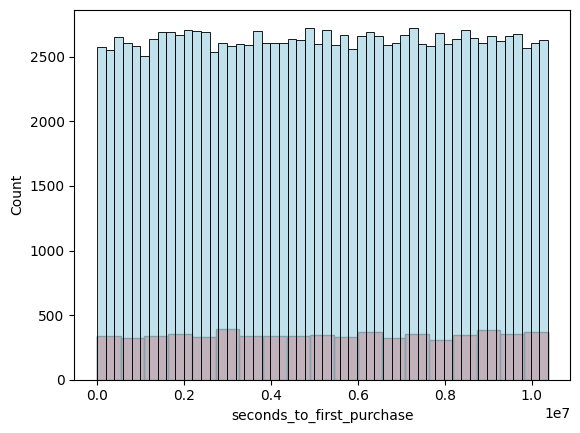

In [263]:
sns.histplot(purchase_data.loc[(purchase_data["class"] ==1) & (purchase_data["seconds_to_first_purchase"] > 1 ), 'seconds_to_first_purchase'], color='red')
sns.histplot(purchase_data.loc[(purchase_data["class"] ==0) & (purchase_data["seconds_to_first_purchase"] > 1 ), 'seconds_to_first_purchase'], color='lightblue')

The histograms of seconds_to_first_purchase looks relatively similar and uniform, suggesting little class separation beyond the 1 second point 

based on this, a binary variable "fast_transaction" in which a value of 1 suggest that the transaction occured too quickly after signup and is likely to be fraudulant. under normal circumstances, we would plot the  KDE of seconds_to_first_purchase for class 1 and class 0 and use the point of intersections, but since the distributions of seconds_to_first_purchase in this data is highly irregular, a large number of 1 second fraudulent transactions combined with a uniform distribution, it will be more efficient to set an informed threshold at 45 seconds which is substantially lower than the the fastest legitimate transaction (137 seconds)

In [267]:
purchase_data['fast_transaction'] = (purchase_data['seconds_to_first_purchase'] <= 45).astype(int)

we now examine whether inconsistent sex, sex and ip can be potential feature

In [268]:
device_sex_age_count = purchase_data.loc[(purchase_data["class"] == 1) ].groupby('device_id')[['sex', 'age', 'ip_address' ]].nunique().reset_index()
device_sex_age_count.loc[((device_sex_age_count["sex"] > 1) | (device_sex_age_count["age"] > 1))  ]

,device_id,sex,age,ip_address
32,ADFZEAZJYIAOI,1,2,2
52,AFLSPILWBHCWY,2,2,2
61,AGGNTUXWDWEWM,2,2,2
76,AHKVPEUBAQBVZ,1,2,2
89,AIDWUFABGXTCG,2,2,2
...,...,...,...,...
6868,ZOZPMMRQPTSCI,2,2,2
6875,ZPJSJOPYHSZWO,2,2,2
6947,ZWSJLUONUPBOU,1,2,2
6965,ZYKQWIDOKNKMW,2,2,2


In [218]:
purchase_data.loc[purchase_data["device_id"].isin(['ADFZEAZJYIAOI']) ].sort_values(by=['purchase_time'])

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_to_first_purchase,country,seconds_to_first_purchase
74703,263235,2015-03-01 19:38:09,2015-05-26 14:10:54,30,ADFZEAZJYIAOI,SEO,Safari,M,27,4.189809e+09,1,85 days 18:32:45,NaN,7410765.0
140490,287649,2015-05-22 11:24:07,2015-07-30 11:48:47,19,ADFZEAZJYIAOI,Ads,Chrome,M,31,4.052775e+09,1,69 days 00:24:40,NaN,5963080.0


In [225]:
device_sex_age_count = purchase_data.loc[(purchase_data["class"] == 0) ].groupby('device_id')[['sex', 'age', 'ip_address' ]].nunique().reset_index()
device_sex_age_count.loc[((device_sex_age_count["sex"] > 1) | (device_sex_age_count["age"] > 1))  ]

,device_id,sex,age,ip_address
34,AAFBODGQYEMVK,2,2,2
61,AAIGAICKBXPSW,2,2,2
190,AAXWKVBISBGWI,2,2,2
218,ABAWKCLFOLYDQ,1,2,2
253,ABGAAIZLGEAPV,2,2,2
...,...,...,...,...
133538,ZZIJMPDZHEFPD,2,2,2
133549,ZZJTXSOBVKLIT,2,2,2
133557,ZZKXASRAZPHYR,2,2,2
133582,ZZOTFEMHJONTA,2,2,2


In [221]:
purchase_data.loc[purchase_data["device_id"].isin(['AAFBODGQYEMVK']) ].sort_values(by=['purchase_time'])

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_to_first_purchase,country,seconds_to_first_purchase
102223,239598,2015-01-18 11:00:53,2015-01-24 11:14:56,41,AAFBODGQYEMVK,Direct,IE,F,30,7.107753e+08,0,6 days 00:14:03,China,519243.0
90032,339951,2015-06-30 03:06:09,2015-10-21 21:43:50,73,AAFBODGQYEMVK,Direct,FireFox,M,33,4.000912e+09,0,113 days 18:37:41,NaN,9830261.0


Under normal circumstances, if the same device ID is registering vastly different sex and age, would be a strong marker for fraudulent transactions. However,there are 3208 devices ID exhibiting this phenomemon but the associated transactions are not fraudulent. 

Thus, we cannot reliably use inconsistent sex, age, and ip as features

we now explore 

In [131]:
obs_browser = np.array([purchase_data.loc[purchase_data["class"] == 0  ,'browser'].value_counts().sort_index(), 
                           purchase_data.loc[purchase_data["class"] == 1  ,'browser'].value_counts().sort_index() ])

chi2_browser = stats.chi2_contingency(obs_browser)

print(purchase_data['browser'].sort_values().unique())
print("obs")
print(obs_browser)
print("exp")
print(chi2_browser[3] )

print( f'statistic = {chi2_browser[0]}, p = {chi2_browser[1]}, dof = {chi2_browser[2]} '  )



['Chrome' 'FireFox' 'IE' 'Opera' 'Safari']
obs
[[55363 22268 33540  3348 22442]
 [ 6069  2342  3187   328  2225]]
exp
[[55679.15289322 22305.37753454 33287.67170708  3331.75813966
  22357.0397255 ]
 [ 5752.84710678  2304.62246546  3439.32829292   344.24186034
   2309.9602745 ]]
statistic = 44.556571734650184, p = 4.916028350364759e-09, dof = 4 


There is a difference in the proportion in browsers used in fraudulent transactions, thus we will use browser as a categorical feature in our model 

We hypothesize that countries with poorer cybersecurity infrastructures are more likely to fall victims to fraud. We map the ip address to countries and examine if we can use country as a feature in our model

In [270]:
country = purchase_data['ip_address'].map(lambda x: ip_data['country'].values[( x >= ip_data["lower_bound_ip_address"]) & (x <= ip_data['upper_bound_ip_address'])])
purchase_data['country'] = [i[0] if len(i) > 0 else np.nan for i in country  ]
# purchase_data['ip_address'].loc[ purchase_data['country'].isna()].nunique()

In [ ]:
purchase_data['country'].isna().sum()

21966

In [281]:
purchase_data.loc[purchase_data["class"] == 0,'country'].dropna().value_counts()[0:5].sort_index().index == purchase_data.loc[purchase_data["class"] == 1,'country'].dropna().value_counts()[0:5].sort_index().index

# the top 10 countries in fraudulent transactions are the same as the top 10 countries in legitimate transactions

array([ True,  True,  True,  True,  True])

In [284]:
top_5_country = purchase_data.loc[purchase_data["class"] == 0,'country'].dropna().value_counts()[0:5].sort_index().index.to_list()

In [285]:
purchase_data.loc[(purchase_data["class"] == 0) & (purchase_data['country'].isin( top_5_country)) ,'country'].value_counts().sort_index()/((purchase_data["class"] == 0) & (purchase_data['country'].isin( top_5_country)) ).sum()

country
China                0.141181
Japan                0.084631
Korea Republic of    0.048563
United Kingdom       0.051529
United States        0.674097
Name: count, dtype: float64

In [286]:
purchase_data.loc[(purchase_data["class"] == 1) & (purchase_data['country'].isin( top_5_country)) ,'country'].value_counts().sort_index()/((purchase_data["class"] == 1) & (purchase_data['country'].isin( top_5_country)) ).sum()

country
China                0.127725
Japan                0.087558
Korea Republic of    0.046534
United Kingdom       0.058413
United States        0.679770
Name: count, dtype: float64

In [288]:
obs_10_country = np.array([purchase_data.loc[(purchase_data["class"] == 0 ) & (purchase_data['country'].isin( top_5_country)),'country'].value_counts().sort_index(), 
                           purchase_data.loc[(purchase_data["class"] == 1 ) & (purchase_data['country'].isin( top_5_country)),'country'].value_counts().sort_index() ])
stats.chi2_contingency(obs_10_country)

Chi2ContingencyResult(statistic=18.004759259298414, pvalue=0.0012314578075682384, dof=4, expected_freq=array([[10895.54770178,  6612.63262246,  3767.01026207,  4063.88180603,
        52539.92760765],
       [ 1142.45229822,   693.36737754,   394.98973793,   426.11819397,
         5509.07239235]]))

Even though there are statistic is significant, it is relatively weak. Thus, we will not use country as a feature 

We hypothesize that fraudulent actors are more likely to have a specific purchase in mind than legitamate actors. Additionally, a common method monetizing stolen CC in which involves using the stolen CC to purchase gift cards. As such, fraudulent actors are more likely to both search for a specific product or directly access the specific product page meaning the purchases will have a higher chance of occurring through SEO and Direct sources. 


In [36]:
purchase_data.loc[purchase_data["class"] == 0,'source'].value_counts()/np.sum(purchase_data["class"] == 0)

source
SEO       0.403056
Ads       0.396960
Direct    0.199984
Name: count, dtype: float64

In [25]:
purchase_data.loc[purchase_data["class"] == 1,'source'].value_counts()/np.sum(purchase_data["class"] == 1)

source
Ads       0.389584
SEO       0.382446
Direct    0.227970
Name: count, dtype: float64

In [32]:
obs = np.array([purchase_data.loc[purchase_data["class"] == 0,'source'].value_counts().sort_index().values, purchase_data.loc[purchase_data["class"] == 1,'source'].value_counts().sort_index().values ])
obs

array([[54368, 27390, 55203],
       [ 5513,  3226,  5412]], dtype=int64)

In [35]:
stats.chi2_contingency(obs)

Chi2ContingencyResult(statistic=64.92317707262569, pvalue=7.981990836440143e-15, dof=2, expected_freq=array([[54273.39748663, 27748.94102388, 54938.66148949],
       [ 5607.60251337,  2867.05897612,  5676.33851051]]))

these results of the chi2-test suggest that our hypothesis is likely to be correct and that fraudulents purchases are more likely to occur through SEO and Direct

We can now construct a prediction model using the selected features. As the features are entirely binary and categorical, we do not need sophisticated models, we shall use a simple decision tree with 5 fold cross validation. 

In [289]:
X = pd.DataFrame({"seconds_to_first_purchase": purchase_data['fast_transaction'],
    "repeated_ip_addr": purchase_data['repeated_ip_addr'],
    "repeated_device_id": purchase_data['repeated_device_id'],
    'source' : purchase_data['source'],
    'browser': purchase_data['browser']
 })

y = purchase_data['class']

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X["source"] = X["source"].astype("category")
X["browser"] = X["browser"].astype("category")

In [309]:
one_hot_X = pd.get_dummies(X,drop_first=True)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

performance = []
fold = 1
for train_index, val_index in skf.split(one_hot_X, y):
    X_train, X_val = one_hot_X.iloc[train_index], one_hot_X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

    clf = DecisionTreeClassifier(criterion='gini')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    performance.append((roc_auc_score(y_val, y_pred), precision_score(y_val, y_pred),recall_score(y_val, y_pred)))
    print(f"Fold {fold} - roc_auc_score: {performance[-1][0]:.4f}, Precision: {performance[-1][1]:.4f}, Recall: {performance[-1][2]:.4f}")
    fold += 1


Fold 1 - roc_auc_score: 0.7678, Precision: 1.0000, Recall: 0.5357
Fold 2 - roc_auc_score: 0.7642, Precision: 1.0000, Recall: 0.5284
Fold 3 - roc_auc_score: 0.7710, Precision: 1.0000, Recall: 0.5420
Fold 4 - roc_auc_score: 0.7724, Precision: 1.0000, Recall: 0.5449
Fold 5 - roc_auc_score: 0.7671, Precision: 1.0000, Recall: 0.5343


In [319]:
np.mean(np.array(performance), axis=0)

array([0.76853256, 1.        , 0.53706513])

With an average AUROC of 0.769, it surpassed the benchmark achieve by AFD-TFI (AUROC = 0.636) 

For completion sake, let also use a more complex model for maximal performance: xgboost with nested cross validation  

In [313]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV



param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

performance = []
fold = 1

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

#     clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, eval_metric='logloss')

    clf = RandomizedSearchCV(
            estimator=xgb.XGBClassifier(tree_method="hist", enable_categorical=True, eval_metric='logloss'),
            param_distributions=param_dist,
            n_iter=10,
            cv=inner_cv,
            scoring='roc_auc',
            n_jobs=-1)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    performance.append((roc_auc_score(y_val, y_pred), precision_score(y_val, y_pred),recall_score(y_val, y_pred)))
    print(f"Fold {fold} - roc_auc_score: {performance[-1][0]:.4f}, Precision: {performance[-1][1]:.4f}, Recall: {accuracies[-1][2]:.4f}")
    fold += 1



Fold 1 - roc_auc_score: 0.7678, Precision: 1.0000, Recall: 0.5343
Fold 2 - roc_auc_score: 0.7642, Precision: 1.0000, Recall: 0.5343
Fold 3 - roc_auc_score: 0.7710, Precision: 1.0000, Recall: 0.5343
Fold 4 - roc_auc_score: 0.7724, Precision: 1.0000, Recall: 0.5343
Fold 5 - roc_auc_score: 0.7671, Precision: 1.0000, Recall: 0.5343


the differences in performance is minimal. suggesting that a with the feature engineering we performed 